# Travel Salesman Problem - Ant Colony Optimization

In [2]:
import numpy as np
import pyspark

In [3]:
paths = [
[0,648,2625,549,2185,1898,1458,1752,1963,427,1743,1817,1899,1060,1148,2084,732,1095,1725,2524],
[648,0,2363,481,2129,2030,1641,1594,1638,557,1214,1492,1710,1126,825,1861,811,1195,1375,2262],
[2625,2362,0,1965,669,1274,1541,920,744,2172,1623,875,720,1595,3085,543,3113,1734,1111,103],
[549,481,1965,0,1667,1605,1194,1132,1242,431,963,1096,1280,664,1249,1464,1276,799,979,1866],
[2185,2129,669,1667,0,621,906,541,643,1733,1504,733,459,1187,2880,479,2791,1169,932,566],
[1898,2030,1274,1605,621,0,443,662,978,1482,1669,925,839,1007,2855,929,2541,843,1107,1172],
[1458,1641,1541,1194,906,443,0,754,1106,1074,1447,976,968,638,2477,1148,2132,435,1027,1442],
[1752,1594,920,1132,541,662,754,0,347,1293,1015,261,209,724,2319,389,2346,841,443,818],
[1963,1638,744,1242,643,978,1106,347,0,1511,961,170,183,970,2361,287,2389,1124,388,688],
[427,557,2172,431,1733,1482,1074,1293,1511,0,1318,1363,1447,585,1378,1631,1063,641,1275,2071],
[1743,1214,1623,963,1504,1669,1447,1015,961,1318,0,813,1078,918,1571,1182,1882,1147,582,1583],
[1817,1492,875,1096,733,925,976,261,170,1363,813,0,271,826,2215,373,2242,979,241,774],
[1899,1710,720,1280,459,839,968,209,183,1447,1078,271,0,882,2453,192,2408,1049,504,621],
[1060,1126,1595,664,1187,1007,638,724,970,585,918,826,882,0,1891,1066,1667,251,798,1495],
[1148,825,3085,1249,2880,2855,2477,2319,2361,1378,1571,2215,2453,1891,0,2583,559,2042,2108,2984],
[2084,1861,543,1464,479,929,1148,389,287,1631,1182,373,192,1066,2583,0,2612,1220,611,442],
[732,811,3113,1276,2791,2541,2132,2346,2389,1063,1882,2242,2408,1667,559,2612,0,1701,2125,3012],
[1095,1195,1734,799,1169,843,435,841,1124,641,1147,979,1049,251,2042,1220,1701,0,977,1634],
[1725,1375,1111,979,932,1107,1027,443,388,1275,582,241,504,798,2108,611,2125,977,0,1011],
[2524,2262,103,1866,566,1172,1442,818,688,2071,1583,774,621,1495,2984,442,3012,1634,1011,0]
]

In [4]:
cities = '''Arizona State
Brigham Young
Brown
Colorado
Duke
Florida State
Louisiana
Louisville
Michigan
NewMexico
North Dakota
Notre Dame
Ohio
Oklahoma
Oregon
Pitt
Stanford
Texas A&M
Wisconsin
Yale'''.split("\n")
cities

['Arizona State',
 'Brigham Young',
 'Brown',
 'Colorado',
 'Duke',
 'Florida State',
 'Louisiana',
 'Louisville',
 'Michigan',
 'NewMexico',
 'North Dakota',
 'Notre Dame',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pitt',
 'Stanford',
 'Texas A&M',
 'Wisconsin',
 'Yale']

In [30]:
M = len(paths)
max_it = 100
N = 100
best_path = []
p = 0.1
Q = 10
t = np.full ([M, M], 1.)
np.fill_diagonal(t, 0)

In [31]:
ants = [{"begin" : np.random.randint(M), "best_cost" : float('inf')} for i in range(N)]
antsRDD = sc.parallelize(ants)

In [38]:
def ACO_Spark(max_it, N):
    M = len(paths)
    best_path = []
    p = 0.1
    Q = 10
    t = np.full ([M, M], 1.)
    np.fill_diagonal(t, 0)
    ants = [{"begin" : np.random.randint(M), "best_cost" : float('inf')} for i in range(N)]
    antsRDD = sc.parallelize(ants)
    
    def ACO (ant):
        current_path = np.full(M, 0)
        current_path[0] = ant["begin"]
        current_node = ant["begin"]
        cost = 0
        e = 1
        while (e < M):
            this_t = np.sum (t[current_node])
            probability = np.divide(t[current_node],this_t)
            next_node = np.random.choice (M, p=probability)
            if next_node not in current_path[0:e]:
                current_path[e] = next_node
                cost += paths[current_node][next_node]
                e += 1
                current_node = next_node
        cost += paths[current_node][ant["begin"]]
        ant["last_cost"] = cost
        ant["last_path"] = current_path
        return ant

    stats = []

    for it in range(max_it):
        ants = antsRDD.map(ACO).collect()
        costs = []
        for ant in ants:
            if ant["last_cost"] < ant["best_cost"]:
                ant["best_cost"] = ant["last_cost"]
                ant["best_path"] = ant["last_path"]
                for k in range (0, M - 1):
                    current_node = int(ant["best_path"][k])
                    next_node = int(ant["best_path"][k + 1])
                    t [current_node][next_node] = t [current_node][next_node] + Q/paths [current_node][next_node]
                current_node = next_node
                next_node = ant["begin"]
                t [current_node][next_node] = t [current_node][next_node] + Q/paths [current_node][next_node]
            costs.append(ant["last_cost"])
        stats.append ({"best_cost" : min(costs), "mean_cost" : np.mean(costs)})
        t = (1-p) * t
        antsRDD = sc.parallelize(ants)
    return stats


In [74]:
def ACO_Serial(max_it, N):
    M = len(paths)
    best_path = []
    p = 0.1
    Q = 10
    t = np.full ([M, M], 1.)
    np.fill_diagonal(t, 0)
    statistics = []
    best_cost = float('inf')

    def ACO (max_it, p, Q):
      statistics = []
      best_cost = float('inf')
      t = np.full ([M, M], 1.)
      np.fill_diagonal(t, 0)
      ants = np.random.randint (M, size=N)
      best_paths = np.full((N),float('inf'))
      ant_paths = np.zeros ((N, M + 1))
      best_ant_paths = np.zeros ((N, M + 1))
      j = 0
      for j in range (0, max_it):
          #print (j)
          current_path = np.full(N, 0)
          for i in range (0, N):
              ant_paths[i][0] = ants[i]
              current_node = ants[i]
              e = 1
              while (e < M):
                  this_t = np.sum (t[current_node])
                  probability = np.divide(t[current_node],this_t)
                  next_node = np.random.choice (M, p=probability)
                  if next_node not in ant_paths[i][0:e]:
                      ant_paths[i][e] = next_node
                      e += 1
                      current_node = next_node
              ant_paths[i][M] = ant_paths[i][0]
              for k in range (0, M):
                  current_node = int(ant_paths[i][k])
                  next_node = int(ant_paths[i][k + 1])
                  #print (current_path[i], paths [current_node][next_node])
                  current_path[i] += paths [current_node][next_node]

          t = (1-p) * t
          for i in range (0, N):
              if current_path[i] < best_paths [i]:
                  best_paths[i] = current_path[i]
                  best_ant_paths[i] = ant_paths[i]
                  for k in range (0, M - 1):
                      current_node = int(ant_paths[i][k])
                      next_node = int(ant_paths[i][k + 1])
                      t [current_node][next_node] = t [current_node][next_node] + Q/paths [current_node][next_node]

          stat = {}
          stat["mean cost"] = np.mean(best_paths)
          stat["best cost"] = np.min(best_paths)
          stat["best path"] = best_ant_paths [np.argmin (best_paths)]
          #if (stat["best cost"] == 9275):
              #print (stat["best path"])
          statistics.append (stat)
      return statistics


    return ACO(max_it, 0.1, 10)



In [ ]:
import time
N = 100
max_it = 60
spark = []
serial = []

for N in range(100, 1000, 100):
    print("N = ", N)
    start = time.time()
    spark.append(ACO_Spark(max_it, N))
    end = time.time()
    print("Spark Time: %.2f s" % (end - start))

    start = time.time()
    serial.append(ACO_Serial(max_it, N))
    end = time.time()
    print("Serial Time: %.2f s" % (end - start))

N =  100
Spark Time: 21.14 s
Serial Time: 64.85 s
N =  200
Spark Time: 44.40 s
Serial Time: 156.31 s
N =  300
Spark Time: 71.75 s
Serial Time: 264.67 s
N =  400
Spark Time: 100.02 s
Serial Time: 387.32 s
N =  500
Spark Time: 125.17 s


In [1]:
spark

In [7]:
nExp = 10

experiments = [ACO(max_it, 0.1, 10) for i in range (0, nExp)]

#  Introdução

O problema do Caixeiro Viajante (Traveling Salesman Problem} é da classe de complexidade NP-Difícil que o número de soluções possíveis aumenta fatorialmente quando o número de cidades cresce. Para resolver essa classe de problemas geralmente é aplicado uma heurística. Neste problema em especial foi utilizado o algoritmo de Otimização por Colônia de Formigas (ACO - Ant Colony Optimization).

## Problema Alvo

O problema utilizado consiste achar o caminho de um menor custo
para um estudante visitar 20 universidades nos Estados Unidos 

### Mapa com localização das universidades

<center>
<img src="https://raw.githubusercontent.com/Guiraiol/Projetos-Mestrado/master/Computa%C3%A7%C3%A3o%20Natural/map.png" style="width:800px;height:600px;">

### Custos das distâncias

<img src="distances.png" style="width:800px;height:600px;">
</center>


## Metodologia Experimental

### Iniciaçlização de parâmetros
- Sendo M o número de cidades: é gerada uma matrix t de tamanho MxM com o feromônio que representa cada ligação entre cidades. 
- Para cada ligação inicialmente são atribuidos um valor 1 de feromônio, e as diagonais são zeradas. 
- São geradas N formigas e cada formiga é posicionada aleatoriamente em um das M cidades. 

### Algoritmo

- Cada nó tem uma probabilidade de ser escolhido de acordo com a razão entre a quantidade de feromônio naquela ligação e a quantidade total de feromônio. 
- Por i iterações, cada formiga decidirá para qual cidade prosseguir escolhendo aleatoriamente uma probabilidade.
- Após isso é calculado o custo do caminho para todas as formigas. As formigas que obtiverem um caminho melhor que o último melhor caminho registrado depositarão pelas conexões em que passaram uma quantidade de feromônio Q dividido pela distância da conexão.
- Antes do depósito de feromônio todas as conexões têm um decaimento p.


Foram realizados 10 experimentos aleatórios, utilizando como parâmetros Q = 10, p = 0.10, um total de 20 cidades, 100 formigas e 70 iterações.

In [ ]:
import matplotlib.pyplot as plt
best_cost = [[stat["best cost"] for stat in statistics] for statistics in experiments]
plt.figure(figsize=(20,10))
plt.ylabel ("Melhor Custo")
plt.xlabel ("Número de Iterações")
plt.plot (np.array(best_cost).T)
plt.legend(["Experimento %d" % i for i in range (0, nExp)])

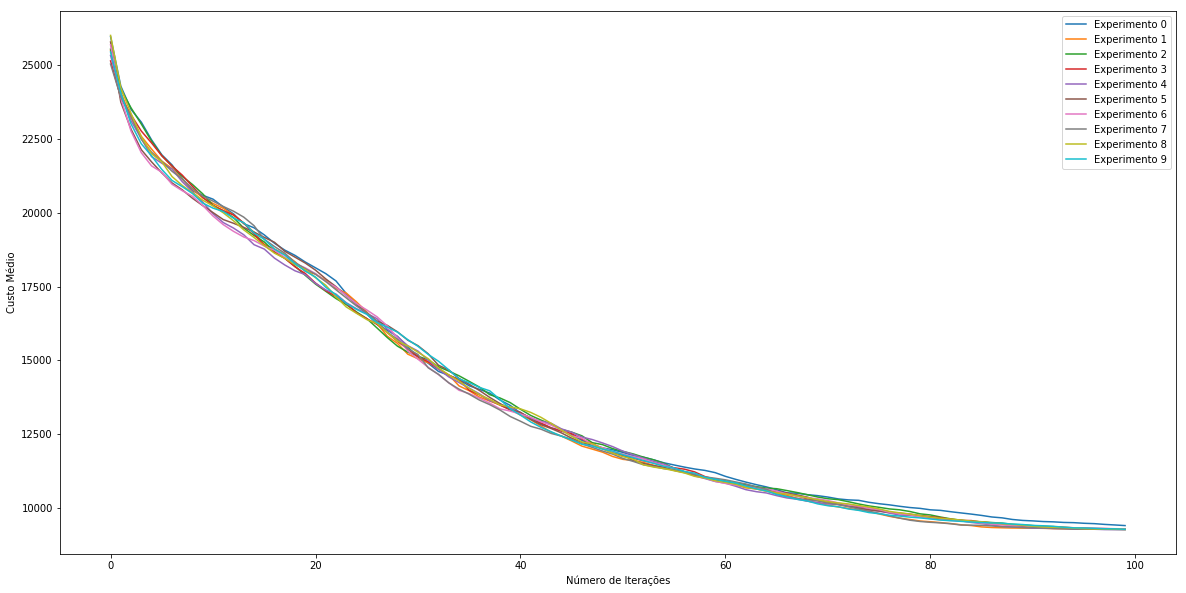

In [9]:
mean_cost = [[stat["mean cost"] for stat in statistics] for statistics in experiments]
plt.figure(figsize=(20,10))
plt.ylabel ("Custo Médio")
plt.xlabel ("Número de Iterações")
plt.plot (np.array(mean_cost).T)
plt.legend(["Experimento %d" % i for i in range (0, nExp)])

### Resultados e Discussão

Os resultados obtidos com Algoritmo Geométrico por BRUCATO (2013) tiveram uma rota com peso 9484. 
Utilizando o ACO foi possível obter uma rota mínima de custo 9275 na iteração 64 do experimento 1. Nessa iteração a média foi de 9331, com desvio padrão de 87.6. 
Na última iteração (70), dois caminhos chegaram a 9275, e a média dos custos ficou em 9284, com desvio padrão de 12.56.

<center>
<img src="min.png" style="width:800px;height:600px">
<img src="mean.png" style="width:800px;height:600px">

</center>

Observou-se que com 100 formigas todos os experimentos tendem a chegar a uma resposta ótima por volta da iteração 70, sendo que após a iteração 75 eles estagnam em 9275. Foi testado também o algoritmo com 50 formigas, que chegou próximo do resultado por volta da 100ª iteração, porém as últimas iterações ficaram consideravelmente mais lentas em termos de tempo de processamento (tendo um tempo total maior que com 100 formigas), isso podendo ocorrer pela quantidade de formigas não suprirem a taxa de evaporação de feromônio, fazendo com que a escolha seja praticamente aleatória. 

O melhor caminho é dado pela sequência: 

Louisville -> Ohio -> Pitt -> Brown -> Yale University -> Duke -> Florida State -> Louisiana -> Texas A&M -> Oklahoma -> New Mexico -> Arizona State -> Stanford -> Oregon -> Brigham Young -> Colorado -> North Dakota -> Wisconsin -> Notre Dame -> Michigan -> Louisville

<center>
<img src="best_path.png" style="width:800px;height:600px">
